# Feature Generation & Model Testing

In [1]:
import pandas as pd
import numpy as np
bids = pd.read_csv('datasets/bids.csv',low_memory=False)
raw_features=pd.read_csv('datasets/bids_w_scores_mean.csv',low_memory=False)
raw_features=raw_features.sort_values(by=['bid_id'],ascending=True).reset_index(drop=True)
raw_features['raw_time']=bids['time']

Previously I included scores based on the amount of bot activity in each device/country/auction site based on the bot activity in the training data. However, the bots in the training data do not give a complete picture of how bots in the entire bids data set may behave, so these features will be deleted.

In [2]:
leaky_feat_list=['percent_robot_device',
 'percent_robot_auction',
 'percent_robot_country',
 'max_device_score_id',
 'max_auction_score_id',
 'max_country_score_id',
 'mean_device_score_id',
 'mean_auction_score_id',
 'mean_country_score_id',]

raw_features.drop(columns=leaky_feat_list,inplace=True)

##  FG1: Average Min and Median Time Between Bids Per Cycle and Overall
One obvious advantage of using automated bidding is that a bot can bid as quickly and frequently as the auction site allows. Comparing the minimum and median time between a user's bid is a method that may help discriminate between human and bot users.

In [3]:
# cycle 1: calculate minimum time between bids and median time between bids (accounts for extremes)
cycle_1_time_sort=raw_features[raw_features.time_period==1][['bid_id','bidder_id','raw_time','time_period','outcome']].sort_values(['raw_time']).reset_index(drop=True)
cycle_1_time_sort['time_between_bid']=cycle_1_time_sort.groupby('bidder_id')['raw_time'].diff()

cycle_1_min_med=pd.DataFrame({"bidder_id": cycle_1_time_sort.bidder_id.unique().tolist()}).set_index(['bidder_id'])
cycle_1_min_med['min_time_btw_bid_c1']=cycle_1_time_sort.groupby('bidder_id')['time_between_bid'].min()
cycle_1_min_med['med_time_btw_bid_c1']=cycle_1_time_sort.groupby('bidder_id')['time_between_bid'].median()
cycle_1_min_med['sum_bids_c1']=cycle_1_time_sort.groupby('bidder_id')['bid_id'].count()
cycle_1_min_med['outcome']=cycle_1_time_sort.drop_duplicates(['bidder_id']).set_index(['bidder_id'])['outcome']
cycle_1_min_med.reset_index(inplace=True)

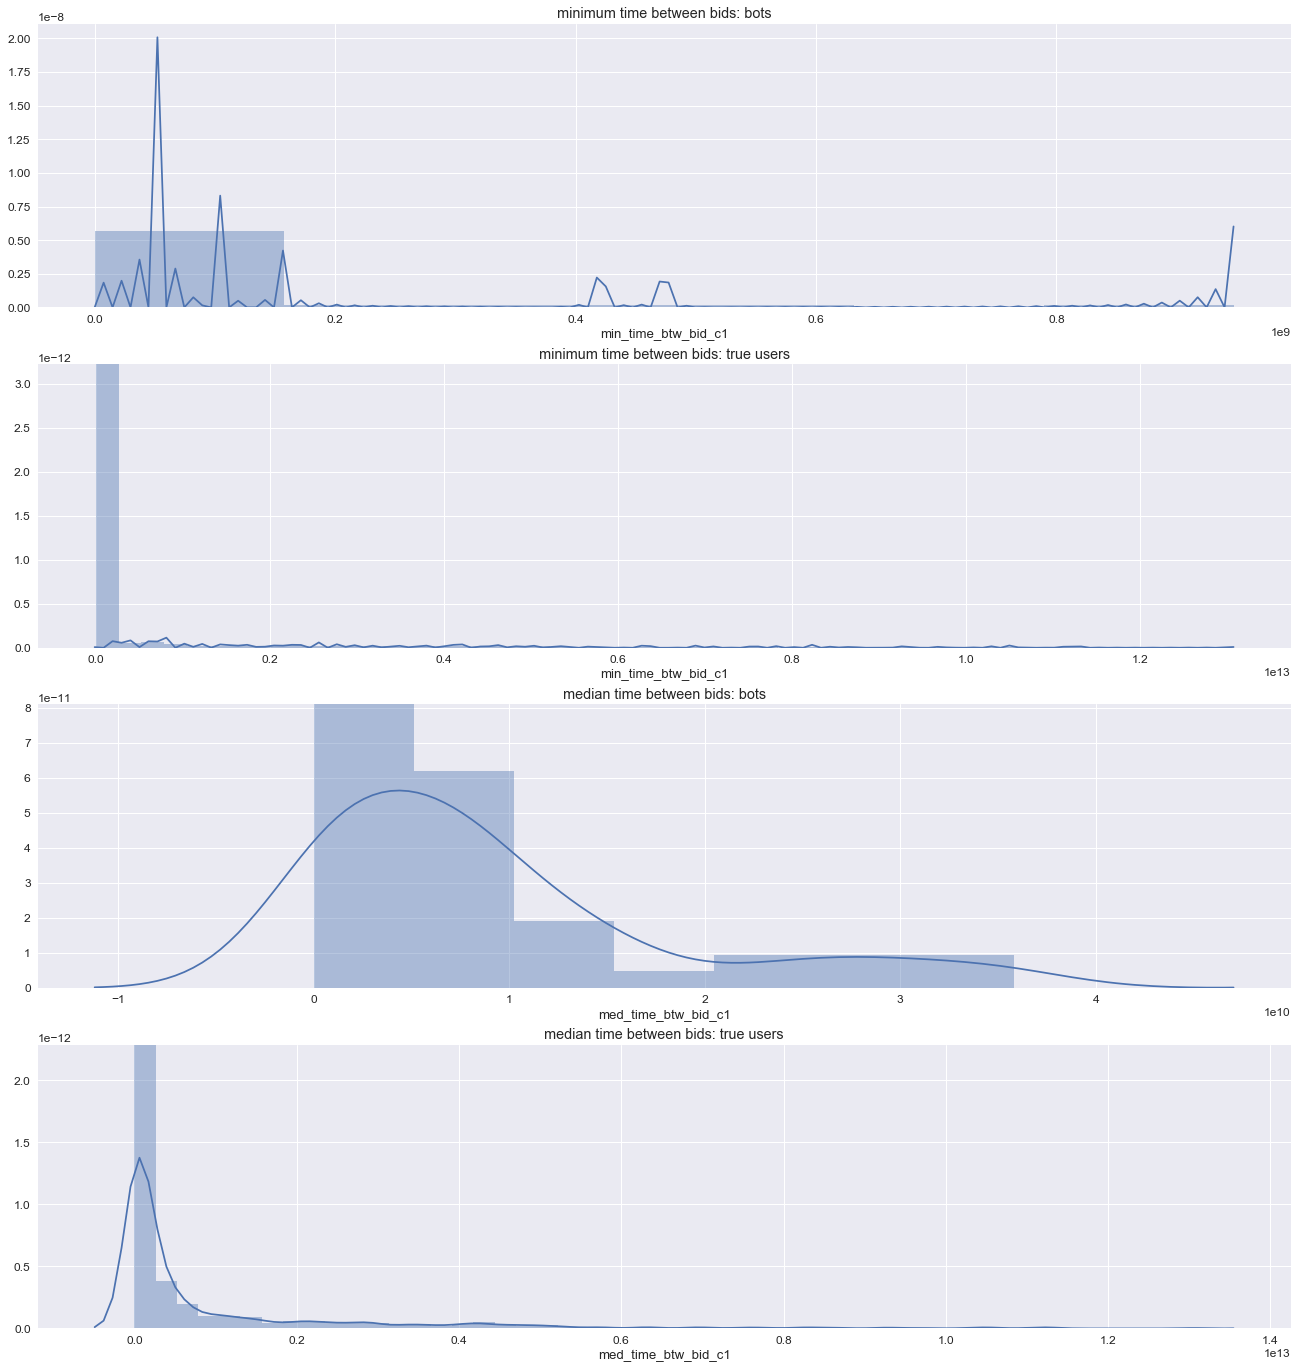

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(figsize=(20,24))
sns.set(font_scale=1.2)

plt.subplot(411)
plt.title("minimum time between bids: bots")
sns.distplot(cycle_1_min_med[cycle_1_min_med['outcome']==1]['min_time_btw_bid_c1'])

plt.subplot(412)
plt.title("minimum time between bids: true users")
sns.distplot(cycle_1_min_med[cycle_1_min_med['outcome']==0]['min_time_btw_bid_c1'].dropna())

plt.subplot(413)
plt.title("median time between bids: bots")
sns.distplot(cycle_1_min_med[cycle_1_min_med['outcome']==1]['med_time_btw_bid_c1'])

plt.subplot(414)
plt.title("median time between bids: true users")
sns.distplot(cycle_1_min_med[cycle_1_min_med['outcome']==0]['med_time_btw_bid_c1'].dropna())

#### Observation
Human users do seem to spread out the time between their bids in cycle 1; these metrics will also be calculated for cycles 2 and 3 as well as overall. 

In [5]:
# cycle 2: calculate minimum time between bids and median time between bids (accounts for extremes)
cycle_2_time_sort=raw_features[raw_features.time_period==2][['bid_id','bidder_id','raw_time','time_period','outcome']].sort_values(['raw_time']).reset_index(drop=True)
cycle_2_time_sort['time_between_bid']=cycle_2_time_sort.groupby('bidder_id')['raw_time'].diff()

cycle_2_min_med=pd.DataFrame({"bidder_id": cycle_2_time_sort.bidder_id.unique().tolist()}).set_index(['bidder_id'])
cycle_2_min_med['min_time_btw_bid_c2']=cycle_2_time_sort.groupby('bidder_id')['time_between_bid'].min()
cycle_2_min_med['med_time_btw_bid_c2']=cycle_2_time_sort.groupby('bidder_id')['time_between_bid'].median()
cycle_2_min_med['sum_bids_c2']=cycle_2_time_sort.groupby('bidder_id')['bid_id'].count()
cycle_2_min_med['outcome']=cycle_2_time_sort.drop_duplicates(['bidder_id']).set_index(['bidder_id'])['outcome']
cycle_2_min_med=cycle_2_min_med.apply(lambda x: x.fillna(x.mean()),axis=0)
cycle_2_min_med.reset_index(inplace=True)

In [6]:
# cycle 3: calculate minimum time between bids and median time between bids (accounts for extremes)
cycle_3_time_sort=raw_features[raw_features.time_period==3][['bid_id','bidder_id','raw_time','time_period','outcome']].sort_values(['raw_time']).reset_index(drop=True)
cycle_3_time_sort['time_between_bid']=cycle_3_time_sort.groupby('bidder_id')['raw_time'].diff()

cycle_3_min_med=pd.DataFrame({"bidder_id": cycle_3_time_sort.bidder_id.unique().tolist()}).set_index(['bidder_id'])
cycle_3_min_med['min_time_btw_bid_c3']=cycle_3_time_sort.groupby('bidder_id')['time_between_bid'].min()
cycle_3_min_med['med_time_btw_bid_c3']=cycle_3_time_sort.groupby('bidder_id')['time_between_bid'].median()
cycle_3_min_med['sum_bids_c3']=cycle_3_time_sort.groupby('bidder_id')['bid_id'].count()
cycle_3_min_med['outcome']=cycle_3_time_sort.drop_duplicates(['bidder_id']).set_index(['bidder_id'])['outcome']
cycle_3_min_med=cycle_3_min_med.apply(lambda x: x.fillna(x.mean()),axis=0)
cycle_3_min_med.reset_index(inplace=True)

In [7]:
# for all cycles
overall_time_sort=raw_features[['bid_id','bidder_id','raw_time','time_period','outcome']].sort_values(['raw_time']).reset_index(drop=True)
overall_time_sort['time_between_bid']=overall_time_sort.groupby('bidder_id')['raw_time'].diff()

overall_min_med=pd.DataFrame({"bidder_id": overall_time_sort.bidder_id.unique().tolist()}).set_index(['bidder_id'])
overall_min_med['min_time_overall']=overall_time_sort.groupby('bidder_id')['time_between_bid'].min()
overall_min_med['med_time_overall']=overall_time_sort.groupby('bidder_id')['time_between_bid'].median()
overall_min_med['outcome']=overall_time_sort.drop_duplicates(['bidder_id']).set_index(['bidder_id'])['outcome']
overall_min_med=overall_min_med.apply(lambda x: x.fillna(x.mean()),axis=0)
overall_min_med.reset_index(inplace=True)

In [8]:
# calculate mean metrics per cycle

c3_users=cycle_3_time_sort['bidder_id'].unique().tolist()
c2_users=cycle_2_time_sort['bidder_id'].unique().tolist()
c1_users=cycle_1_time_sort['bidder_id'].unique().tolist()

c12_users=list(set(c1_users).intersection(c2_users))

In [9]:
print "number of users that participated in all cycles"
print len(list(set(c1_users).intersection(c2_users,c3_users)))
print "number of users that participated in both cycle 1 and cycle 2"
print len(list(set(c1_users).intersection(c2_users)))
print "number of users that participated in both cycle 1 and cycle 3"
print len(list(set(c1_users).intersection(c3_users)))
print "number of users that participated in cycle 1 but not cycle 2"
print len(c1_users) - 2370
print "number of users that participated in cycle 2 but not cycle 1"
print len(c2_users) - 2370
print "number of users that only participated in cycle 3"
print len(c3_users)

number of users that participated in all cycles
0
number of users that participated in both cycle 1 and cycle 2
2370
number of users that participated in both cycle 1 and cycle 3
0
number of users that participated in cycle 1 but not cycle 2
646
number of users that participated in cycle 2 but not cycle 1
644
number of users that only participated in cycle 3
2954


In [10]:
# calculate mean metrics per cycle
# fill metrics for single bidders with 0
# cycle 1 and 2 overlap
c12_min_med=pd.merge(cycle_1_min_med,cycle_2_min_med,on=['bidder_id','bidder_id'])
c12_min_med['min_time_btw_bid_cycle']=(c12_min_med['min_time_btw_bid_c1']+c12_min_med['min_time_btw_bid_c2'])/2
c12_min_med['med_time_btw_bid_cycle']=(c12_min_med['med_time_btw_bid_c1']+c12_min_med['med_time_btw_bid_c2'])/2
c12_min_med['avg_sum_bid_cycle']=(c12_min_med['sum_bids_c1']+c12_min_med['sum_bids_c2'])/2
c12_min_med=c12_min_med[['bidder_id','min_time_btw_bid_cycle','med_time_btw_bid_cycle','avg_sum_bid_cycle']]
#cycle 3 no overlap
cycle_3_self=cycle_3_min_med[['bidder_id','min_time_btw_bid_c3','med_time_btw_bid_c3','sum_bids_c3']]
cycle_3_self.columns=['bidder_id','min_time_btw_bid_cycle','med_time_btw_bid_cycle','avg_sum_bid_cycle']
#cycle 1 no overlap
cycle_1_self=cycle_1_min_med[~cycle_1_min_med.bidder_id.isin(c12_users)].drop(columns=['outcome'])
cycle_1_self.columns=['bidder_id','min_time_btw_bid_cycle','med_time_btw_bid_cycle','avg_sum_bid_cycle']
#cycle 2 no overlap
cycle_2_self=cycle_2_min_med[~cycle_2_min_med.bidder_id.isin(c12_users)].drop(columns=['outcome'])
cycle_2_self.columns=['bidder_id','min_time_btw_bid_cycle','med_time_btw_bid_cycle','avg_sum_bid_cycle']
#concat all cycles create column for bidders who only bid once
all_cycle_min_med=pd.concat([c12_min_med,cycle_3_self,cycle_1_self,cycle_2_self])
all_cycle_min_med=all_cycle_min_med.merge(overall_min_med,on=['bidder_id','bidder_id']).drop(columns=['outcome'])



In [11]:
#fill missing values by column means 
# even though only 5/304 users who made 1 bid were bots (1140/6614 is too wide to assume that all one bidders are true)
all_cycle_filled=all_cycle_min_med.set_index(['bidder_id'])
all_cycle_filled=all_cycle_filled.apply(lambda x: x.fillna(x.mean()),axis=0).reset_index()

In [12]:
features_w_all_cycle=pd.merge(all_cycle_filled,raw_features.drop_duplicates(['bidder_id']),on=['bidder_id','bidder_id'])

In [13]:
rf_list=['outcome','bidder_id','total_bids_by_id','total_bids_within_15_mins_by_id',\
'perc_bids_within_15_mins_by_id','total_bids_within_30_mins_by_id','perc_bids_within_30_mins_by_id',\
'entropy','mean_ip_count_per_cycle','mean_url_count_per_cycle','mean_dev_count_per_cycle',\
'mean_country_count_per_cycle','mean_auction_count_per_cycle']
features_w_all_cycle=pd.merge(all_cycle_filled,raw_features[rf_list].drop_duplicates(['bidder_id']),on=['bidder_id','bidder_id'])

## FG1: Number of Consecutive Bids Made In Each Cycle And Mean Number of Bids Between Consecutive Bids

In [14]:
train=pd.read_csv('datasets/train.csv')
test=pd.read_csv('datasets/test.csv')
bids=bids.merge(raw_features[['bid_id','time_period']],on=['bid_id','bid_id'])
bids_w_outcome=bids.merge(train[['bidder_id','outcome']],on=['bidder_id','bidder_id'],how='left')

In [15]:
print "number of unique bot bidders in cycle 1"
print bids_w_outcome[(bids_w_outcome.time_period==1)&((bids_w_outcome.outcome==1))]['bidder_id'].nunique()
print "number of bids made by bots in cycle 1"
print bids_w_outcome[(bids_w_outcome.time_period==1)&((bids_w_outcome.outcome==1))]['bid_id'].nunique()
print "number of unique true bidders in cycle 1"
print bids_w_outcome[(bids_w_outcome.time_period==1)&((bids_w_outcome.outcome==0))]['bidder_id'].nunique()
print "number of bids made by true bidders in cycle 1"
print bids_w_outcome[(bids_w_outcome.time_period==1)&((bids_w_outcome.outcome==0))]['bid_id'].nunique()

number of unique bot bidders in cycle 1
41
number of bids made by bots in cycle 1
113828
number of unique true bidders in cycle 1
891
number of bids made by true bidders in cycle 1
1079626


In [16]:
cycle_1_bidders=bids[bids.time_period==1]['bidder_id'].unique().tolist()

c1_bids=bids[(bids['time_period']==1)][['bid_id','bidder_id']].sort_values(by=['bid_id'])
c1_consec=[]
c1_lag_mean=[]

#count number of consecutive bids per bidder in cycle 1 and the mean amount of bids spent between consecutive bids
for c in cycle_1_bidders:
    if cycle_1_bidders.index(c)%500==0:
        print "Review %d of %d" % (cycle_1_bidders.index(c), len(cycle_1_bidders))
    aaa=c1_bids[(c1_bids.bidder_id==c)]['bid_id'].diff().to_frame()
    c1_consec.append(len(aaa[aaa.bid_id==1]))
    try:
        c1_lag_mean.append(np.mean(aaa[aaa.bid_id!=1]['bid_id']))
    except:
        c1_lag_mean.append(0) 

Review 0 of 3016
Review 500 of 3016
Review 1000 of 3016
Review 1500 of 3016
Review 2000 of 3016
Review 2500 of 3016
Review 3000 of 3016


In [17]:
cycle_2_bidders=bids[bids.time_period==2]['bidder_id'].unique().tolist()

c2_bids=bids[(bids['time_period']==2)][['bid_id','bidder_id']].sort_values(by=['bid_id'])
c2_consec=[]
c2_lag_mean=[]

#count number of consecutive bids per bidder in cycle 1 and the mean amount of bids spent between consecutive bids
for c in cycle_2_bidders:
    if cycle_2_bidders.index(c)%500==0:
        print "Review %d of %d" % (cycle_2_bidders.index(c), len(cycle_2_bidders))
    aaa=c2_bids[(c2_bids.bidder_id==c)]['bid_id'].diff().to_frame()
    c2_consec.append(len(aaa[aaa.bid_id==1]))
    try:
        c2_lag_mean.append(np.mean(aaa[aaa.bid_id!=1]['bid_id']))
    except:
        c2_lag_mean.append(0) 

Review 0 of 3014
Review 500 of 3014
Review 1000 of 3014
Review 1500 of 3014
Review 2000 of 3014
Review 2500 of 3014
Review 3000 of 3014


In [18]:
cycle_3_bidders=bids[bids.time_period==3]['bidder_id'].unique().tolist()

c3_bids=bids[(bids['time_period']==3)][['bid_id','bidder_id']].sort_values(by=['bid_id'])
c3_consec=[]
c3_lag_mean=[]

#count number of consecutive bids per bidder in cycle 1 and the mean amount of bids spent between consecutive bids
for c in cycle_3_bidders:
    if cycle_3_bidders.index(c)%500==0:
        print "Review %d of %d" % (cycle_3_bidders.index(c), len(cycle_3_bidders))
    aaa=c3_bids[(c3_bids.bidder_id==c)]['bid_id'].diff().to_frame()
    c3_consec.append(len(aaa[aaa.bid_id==1]))
    try:
        c3_lag_mean.append(np.mean(aaa[aaa.bid_id!=1]['bid_id']))
    except:
        c3_lag_mean.append(0) 

Review 0 of 2954
Review 500 of 2954
Review 1000 of 2954
Review 1500 of 2954
Review 2000 of 2954
Review 2500 of 2954


In [928]:
# calculate mean metrics per cycle
#fill bidders who made one bid with column mean except overlapping cycles

c1_consdf=pd.DataFrame({'bidder_id': cycle_1_bidders, 'c1_consec': c1_consec, 'c1_lag_mean': c1_lag_mean})
c2_consdf=pd.DataFrame({'bidder_id': cycle_2_bidders, 'c2_consec': c2_consec, 'c2_lag_mean': c2_lag_mean})
c3_consdf=pd.DataFrame({'bidder_id': cycle_3_bidders, 'mean_consec_bid': c3_consec, 'mean_lag': c3_lag_mean})
c3_consdf['mean_lag']=c3_consdf['mean_lag'].fillna(c3_consdf['mean_lag'].mean())

# cycle 1 and 2 overlap
c12_consdf=pd.merge(c1_consdf,c2_consdf,on=['bidder_id','bidder_id'])
c12_consdf=c12_consdf.fillna(0)
c12_consdf['mean_consec_bid']=(c12_consdf['c1_consec']+c12_consdf['c2_consec'])/2
c12_consdf['mean_lag']=(c12_consdf['c1_lag_mean']+c12_consdf['c2_lag_mean'])/2
c12_consdf=c12_consdf[['bidder_id','mean_consec_bid','mean_lag']]

#cycle 1 no overlap
c1_consdf_self=c1_consdf[~c1_consdf.bidder_id.isin(c12_users)]
c1_consdf_self.iloc[:,1:]=c1_consdf_self.iloc[:,1:].apply(lambda x: x.fillna(x.mean()),axis=0)
c1_consdf_self.columns=['bidder_id','mean_consec_bid','mean_lag']

#cycle 2 no overlap
c2_consdf_self=c2_consdf[~c2_consdf.bidder_id.isin(c12_users)]
c2_consdf_self.iloc[:,1:]=c2_consdf_self.iloc[:,1:].apply(lambda x: x.fillna(x.mean()),axis=0)
c2_consdf_self.columns=['bidder_id','mean_consec_bid','mean_lag']

#concat all cycles create column for bidders who only bid once
all_cycle_consec=pd.concat([c12_consdf,c3_consdf,c1_consdf_self,c2_consdf_self])
all_cycle_consec.columns=['bidder_id','mean_consec_bid','mean_bid_lag']

/Users/Sean/anaconda3/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
#dropping 15/30 min in favor of consecutive bids as a measure of faster bidding
feat_list=['bidder_id','total_bids_by_id','entropy','mean_ip_count_per_cycle',\
           'mean_url_count_per_cycle','mean_dev_count_per_cycle','mean_country_count_per_cycle',\
           'mean_auction_count_per_cycle','outcome']
feat_add_consec=raw_features[feat_list].drop_duplicates(['bidder_id'])
consec_min_med_cycle=all_cycle_min_med.merge(all_cycle_consec).merge(feat_add_consec)


In [933]:
consec_min_med_cycle['min_time_btw_bid_cycle']=consec_min_med_cycle['min_time_btw_bid_cycle'].fillna(consec_min_med_cycle['min_time_btw_bid_cycle'].mean())
consec_min_med_cycle['med_time_btw_bid_cycle']=consec_min_med_cycle['med_time_btw_bid_cycle'].fillna(consec_min_med_cycle['med_time_btw_bid_cycle'].mean())

In [935]:
consec_min_med_cycle.isnull().sum()

bidder_id                          0
min_time_btw_bid_cycle             0
med_time_btw_bid_cycle             0
avg_sum_bid_cycle                  0
min_time_overall                   0
med_time_overall                   0
mean_consec_bid                    0
mean_bid_lag                       0
total_bids_by_id                   0
entropy                            0
mean_ip_count_per_cycle            0
mean_url_count_per_cycle           0
mean_dev_count_per_cycle           0
mean_country_count_per_cycle       0
mean_auction_count_per_cycle       0
outcome                         4630
dtype: int64

## FG1: Auction and Device Categories For Single Bidding Users
Up to now, I have generated features that are useful for analyzing users that have made multiple bids. However a significant amount of the users in the test set have made only a single bid. The most accessible feature that may provide some insight into whether single bidding users are bots or humans are the categorical features that are listed in their bid logs.

In [23]:
print "number of unique bidders in auction"
print len(consec_min_med_cycle)
print "number of unique bidders that made one bid"
print len(consec_min_med_cycle[consec_min_med_cycle.total_bids_by_id==1])
print "number of true bidders that made one bid"
print len(consec_min_med_cycle[(consec_min_med_cycle.outcome==0)&(consec_min_med_cycle.total_bids_by_id==1)])
print "number of bot bidders that made one bid"
print len(consec_min_med_cycle[(consec_min_med_cycle.outcome==1)&(consec_min_med_cycle.total_bids_by_id==1)])

number of unique bidders in auction
6614
number of unique bidders that made one bid
1057
number of true bidders that made one bid
297
number of bot bidders that made one bid
5


In [24]:
true_single=consec_min_med_cycle[(consec_min_med_cycle.outcome==0)&(consec_min_med_cycle.total_bids_by_id==1)]['bidder_id'].tolist()
bot_single=consec_min_med_cycle[(consec_min_med_cycle.outcome==1)&(consec_min_med_cycle.total_bids_by_id==1)]['bidder_id'].tolist()
na_single=consec_min_med_cycle[(consec_min_med_cycle.outcome.isnull())&(consec_min_med_cycle.total_bids_by_id==1)]['bidder_id'].tolist()
all_single=consec_min_med_cycle[(consec_min_med_cycle.total_bids_by_id==1)]['bidder_id'].tolist()

In [47]:
bids[bids['bidder_id'].isin(true_single)].nunique().sort_values(ascending=False)

time           297
bidder_id      297
bid_id         297
ip             286
auction        205
url            165
device         142
country         44
merchandise      8
time_period      3
dtype: int64

In [48]:
bids[(bids['bidder_id'].isin(bot_single))].nunique().sort_values(ascending=False)

url            5
ip             5
time           5
device         5
auction        5
bidder_id      5
bid_id         5
country        4
merchandise    4
time_period    2
dtype: int64

In [46]:
bids[(bids['bidder_id'].isin(na_single))].nunique().sort_values(ascending=False)

time           755
bidder_id      755
bid_id         755
ip             685
url            414
auction        389
device         243
country         59
merchandise      9
time_period      3
dtype: int64

In [28]:
print "bot unique categories:"
print "auction"
print bids[(bids['bidder_id'].isin(bot_single))]['auction'].unique()
print "device"
print bids[(bids['bidder_id'].isin(bot_single))]['device'].unique()
print "url"
print bids[(bids['bidder_id'].isin(bot_single))]['url'].unique()

bot unique categories:
auction
['jefix' 'opnq4' 'enf1x' 'b6zck' 'jqx39']
device
['phone55' 'phone58' 'phone239' 'phone110' 'phone15']
url
['8dnl2a72zcebtol' 'xyo3dohgsmmd1y4' '9kr6pu92oukxjok' 'vfetcllsdf5qia2'
 'pkegaymari9jblo']


In [29]:
print "human categories that are shared with single bidding bots"
print "auction"
print bids[(bids.bidder_id.isin(true_single))&(bids.auction.isin(bids[(bids['bidder_id'].isin(bot_single))]['auction'].unique()))]['auction'].unique()
print "device"
print bids[(bids.bidder_id.isin(true_single))&(bids.device.isin(bids[(bids['bidder_id'].isin(bot_single))]['device'].unique()))]['device'].unique()
print "url"
print bids[(bids.bidder_id.isin(true_single))&(bids.url.isin(bids[(bids['bidder_id'].isin(bot_single))]['url'].unique()))]['url'].unique()
# auction won't be a good measure to distinguish between the two but device and url might

human categories that are shared with single bidding bots
auction
['jefix' 'jqx39' 'enf1x' 'opnq4' 'b6zck']
device
['phone58' 'phone15' 'phone55' 'phone110']
url
[]


In [30]:
print "NA categories that are shared with single bidding bots"
print "auction"
print bids[(bids.bidder_id.isin(na_single))&(bids.auction.isin(bids[(bids['bidder_id'].isin(bot_single))]['auction'].unique()))]['auction'].unique()
print "device"
print bids[(bids.bidder_id.isin(na_single))&(bids.device.isin(bids[(bids['bidder_id'].isin(bot_single))]['device'].unique()))]['device'].unique()
print "url"
print bids[(bids.bidder_id.isin(na_single))&(bids.url.isin(bids[(bids['bidder_id'].isin(bot_single))]['url'].unique()))]['url'].unique()
# auction won't be a good measure to distinguish between the two but device and url might

NA categories that are shared with single bidding bots
auction
['jefix' 'b6zck' 'jqx39' 'opnq4' 'enf1x']
device
['phone55' 'phone15' 'phone110' 'phone58']
url
['pkegaymari9jblo']


In [31]:
print "NA categories that are shared with single bidding humans"
print "auction"
print len(bids[(bids.bidder_id.isin(na_single))&(bids.auction.isin(bids[(bids['bidder_id'].isin(true_single))]['auction'].unique()))]['auction'].unique())
print "device"
print len(bids[(bids.bidder_id.isin(na_single))&(bids.device.isin(bids[(bids['bidder_id'].isin(true_single))]['device'].unique()))]['device'].unique())
print "url"
print len(bids[(bids.bidder_id.isin(na_single))&(bids.url.isin(bids[(bids['bidder_id'].isin(true_single))]['url'].unique()))]['url'].unique())
# auction won't be a good measure to distinguish between the two but device and url might

NA categories that are shared with single bidding humans
auction
75
device
93
url
1


I have opted to create features that represent the percent of bids made under each category per user. I will do this by creating dummy variables for the devices, auctions, and countries that single bidding users in the training set participated in, summing the amount of bids a user made from those categories, then dividing these bids by the total bids a user made.

In [49]:
# device, auctions, country that overlap between single bidding true users and single bidding unknowns
device_dummies=bids[(bids['bidder_id'].isin(na_single))]['device'].unique()
auction_dummies=bids[(bids['bidder_id'].isin(na_single))]['auction'].unique()
country_dummies=bids[(bids['bidder_id'].isin(na_single))]['country'].unique()
#adding url too
url_dummies=bids[(bids['bidder_id'].isin(na_single))]['url'].unique()
#filter bids df to show bids placed per category
device_dum_df=bids[bids.device.isin(device_dummies)][['bidder_id','device']]
auction_dum_df=bids[bids.auction.isin(auction_dummies)][['bidder_id','auction']]
country_dum_df=bids[bids.country.isin(country_dummies)][['bidder_id','country']]
url_dum_df=bids[bids.url.isin(url_dummies)][['bidder_id','url']]

In [58]:
#counts for auction
auction_cat=pd.get_dummies(auction_dum_df,columns=['auction'])
auction_cat1=auction_cat.groupby(['bidder_id'])[auction_cat.columns.tolist()[1:]].sum().reset_index()
#counts for device
device_cat=pd.get_dummies(device_dum_df,columns=['device'])
device_cat1=device_cat.groupby(['bidder_id'])[device_cat.columns.tolist()[1:]].sum().reset_index()
#counts for country
country_cat=pd.get_dummies(country_dum_df,columns=['country'])
country_cat1=country_cat.groupby(['bidder_id'])[country_cat.columns.tolist()[1:]].sum().reset_index()
#counts for url
url_cat=pd.get_dummies(url_dum_df,columns=['url'])
url_cat1=url_cat.groupby(['bidder_id'])[url_cat.columns.tolist()[1:]].sum().reset_index()
#merge and fillna with 0 (category not present in column)
na_cat_df=bids[['bidder_id']].drop_duplicates().merge(auction_cat1,on=['bidder_id','bidder_id'],how='outer')\
                                                .merge(device_cat1,on=['bidder_id','bidder_id'],how='outer')\
                                                .merge(country_cat1,on=['bidder_id','bidder_id'],how='outer')\
                                                .merge(url_cat1,on=['bidder_id','bidder_id'],how='outer').fillna(0)

In [878]:
#divide categories by total bids by id
na_cat_df=consec_min_med_cycle[['bidder_id','total_bids_by_id']].merge(na_cat_df,on=['bidder_id'])

for c in na_cat_df.columns.tolist()[2:]:
    na_cat_df[c]=na_cat_df[c]/na_cat_df['total_bids_by_id']
na_cat_df.drop(columns=['total_bids_by_id'],inplace=True)

#  Part III: Model Testing 1
## Fill Missing Values and Scale
Now that there are a decent amount of features, it is worth looking into doing some preliminary testing to see how the model performs initially. I will be opting to fill null values with column means and scaling numeric values using sklearn's StandardScaler.

In [60]:
#merge category with inactive test users fill nans as column average then scale
train_ids=train['bidder_id']
test_ids=test['bidder_id']
consec_min_med_cycle_w_cat=consec_min_med_cycle.merge(na_cat_df)
# divide categorical sums by total_bids_by_id to get percent of bids placed per category
for c in na_cat_df.columns.tolist()[1:]:
    consec_min_med_cycle_w_cat[c]=(1.0*consec_min_med_cycle_w_cat[c]/consec_min_med_cycle_w_cat['total_bids_by_id'])

#merge inactive users from test group/drop outcomes column
w_inactive_test=consec_min_med_cycle_w_cat.merge(test['bidder_id'].to_frame(),how='outer').drop(columns=['outcome'])

#fill inactive users with 0
#w_inactive_test.iloc[:,1:]=w_inactive_test.iloc[:,1:].fillna(0)

#fill nan with column averages
w_inactive_test.iloc[:,1:]=w_inactive_test.iloc[:,1:].apply(lambda x: x.fillna(x.mean()),axis=0)

In [63]:
#prescaled features df
prescaled_w_inactive=w_inactive_test.copy()

#scale
from sklearn.preprocessing import StandardScaler #Standardisation

features_to_scale=w_inactive_test.columns[1:].tolist()

for f in features_to_scale:
    w_inactive_test[f]=StandardScaler().fit_transform(w_inactive_test[f].as_matrix().reshape(-1,1)).flatten()

In [64]:
train_ids=train['bidder_id']
test_ids=test['bidder_id']

## Investigating Initial Model Performance

In [65]:
#split into train and unknown features / assign y as outcome drop outcome for X
Y=train[['bidder_id','outcome']].merge(w_inactive_test)['outcome']
X=train[['bidder_id','outcome']].merge(w_inactive_test).drop(columns=['outcome']).iloc[:,1:]
train_ids=train['bidder_id']
#unknown features
unk_features=w_inactive_test[w_inactive_test.bidder_id.isin(test['bidder_id'])].iloc[:,1:]
unk_ids=w_inactive_test[w_inactive_test.bidder_id.isin(test['bidder_id'])]['bidder_id']

In [69]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

training_features=train[['bidder_id','outcome']].merge(w_inactive_test).iloc[:,1:]

# split features
train_split,test_split=train_test_split(training_features,test_size=0.25,random_state=0,stratify=training_features['outcome'])

train_X=train_split.drop(columns=['outcome'])
train_Y=train_split['outcome']
test_X=test_split.drop(columns=['outcome'])
test_Y=test_split['outcome']


# create pipeline
estimators = []
estimators.append(('dtc', DecisionTreeClassifier(class_weight='balanced')))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=0)
results = cross_val_score(model, X, Y, cv=10, scoring='roc_auc')
print(results.mean())

0.690767630714


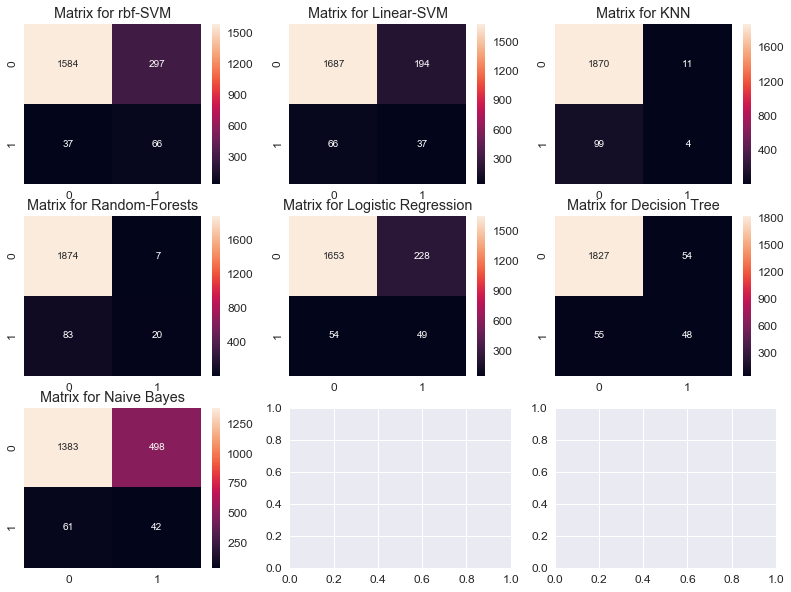

In [67]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf',class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')

y_pred = cross_val_predict(svm.SVC(kernel='linear',class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100,class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')

y_pred = cross_val_predict(LogisticRegression(class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')

y_pred = cross_val_predict(DecisionTreeClassifier(class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')

y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

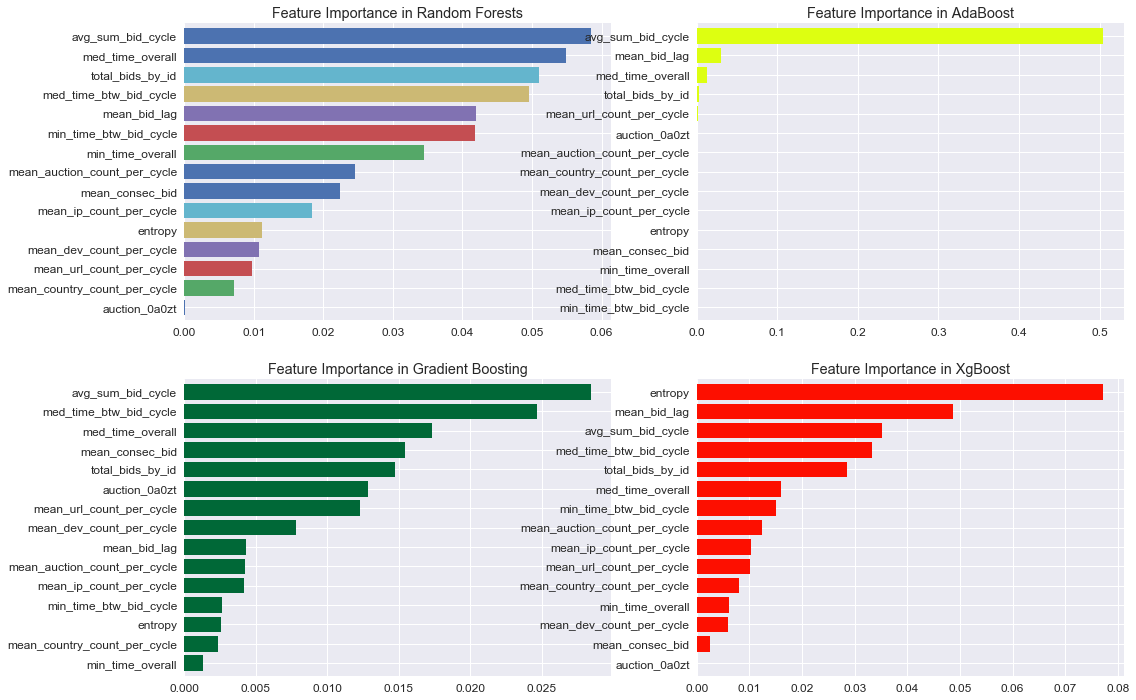

In [85]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xg

f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0,class_weight='balanced')
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=False)[:15].plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')

model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=False)[:15].plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')

model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=False)[:15].plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')

model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=False)[:15].plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

0.700567246301
             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97      1881
        1.0       0.47      0.43      0.45       103

avg / total       0.94      0.95      0.94      1984



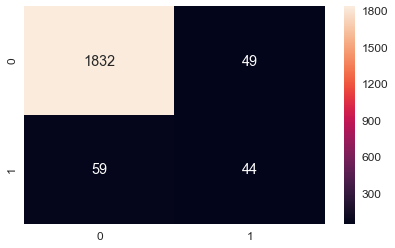

In [78]:
from sklearn.model_selection import cross_val_predict
import sklearn
sns.set(font_scale=1.2)

y_pred = cross_val_predict(DecisionTreeClassifier(class_weight='balanced'),X,Y,cv=10)
from sklearn.metrics import roc_auc_score
print roc_auc_score(Y, y_pred)

# Classif report and conf mat
print sklearn.metrics.classification_report(Y, y_pred)
sns.heatmap(confusion_matrix(Y,y_pred),annot=True,fmt='2.0f')
plt.show()

In [80]:
#analyzing bots with wrong predictions
missed_predictions=pd.DataFrame({'bidder_id': train[['bidder_id','outcome']].merge(prescaled_w_inactive)['bidder_id'], 'true_outcome': Y, 'predicted_outcome': y_pred})
missed_true_id= missed_predictions[(missed_predictions.predicted_outcome!=missed_predictions.true_outcome)&(missed_predictions.true_outcome==0)]['bidder_id'].tolist()
missed_bot_id= missed_predictions[(missed_predictions.predicted_outcome!=missed_predictions.true_outcome)&(missed_predictions.true_outcome==1)]['bidder_id'].tolist()

In [109]:
#comparing the mean stats of bot users to missed bots
[consec_min_med_cycle[consec_min_med_cycle.bidder_id.isin(missed_bot_id)].iloc[:,1:-1].mean()/consec_min_med_cycle[consec_min_med_cycle.outcome==1].iloc[:,1:-1].mean()]

[min_time_btw_bid_cycle          0.335378
 med_time_btw_bid_cycle          0.591331
 avg_sum_bid_cycle               0.889900
 min_time_overall                1.744798
 med_time_overall                1.723908
 mean_consec_bid                 0.464730
 mean_bid_lag                    0.819408
 total_bids_by_id                0.702731
 entropy                         0.963762
 mean_ip_count_per_cycle         0.844437
 mean_url_count_per_cycle        1.349511
 mean_dev_count_per_cycle        1.232804
 mean_country_count_per_cycle    1.253081
 mean_auction_count_per_cycle    1.235941
 dtype: float64]

#### Observation
Missed bots tend to have fewer consecutive bids and bids slower compared to the average bot user. Looking back on these features though, it may be more effective to classify the minimum and median time between bids as the time between a user's bid and the next user's bid as opposed the time between a user's bid and the same user's next bid. After all, a bot may be able to enter the auction as soon as a vacancy is available faster than a true user would. This feature would also include single bidding users, which make up a big portion of the users in the test set.

# Part IV: Feature Generation 2
## FG2: Auction and Bidding Behavior for Bidders in Individual Auctions
Until now, features have been generated on a macroscopic scale looking at bidding behavior over the entire bidding log set. By looking at a user's behavior on a smaller scale of individual auctions, some features created may be able to boost the model's performance. I will be looking into whether a user placed a bid first/last in an auction, the percentage of bids a user placed in that user's most bidded-in auction, and a user's participation in the site's most popular auctions.

In [576]:
auction_df=bids.sort_values(['auction','time','bid_id'])
auction_df['auction_bid_id']=np.arange(0,len(auction_df),1)
#make series with times of first bid per auction 
auction_min_time_series=auction_df.groupby(['auction'])['time'].min().reset_index()
auction_min_time_series['first_bid_auc']=1
#merge with auction dataframe/there are multiple first bids
auction_df=auction_df.merge(auction_min_time_series,on=['auction','time'],how='left').fillna(0)
#make series with times of last bid per auction 
auction_max_time_series=auction_df.groupby(['auction'])['time'].max().reset_index()
auction_max_time_series['last_bid_auc']=1
#merge with auction dataframe/there are multiple first bids
auction_df=auction_df.merge(auction_max_time_series,on=['auction','time'],how='left').fillna(0)

In [577]:
#actual first to get processed by auction site system
auction_actual_first=auction_df[auction_df['first_bid_auc']==1].groupby(['auction'])['bid_id'].min().reset_index()
auction_actual_first['actual_first_bid']=1
#actual last to get processed first
auction_actual_last=auction_df[auction_df['last_bid_auc']==1].groupby(['auction'])['bid_id'].min().reset_index()
auction_actual_last['actual_last_bid']=1
#merge with auction dataframe
auction_df=auction_df.merge(auction_actual_first,on=['auction','bid_id'],how='left').fillna(0).merge(auction_actual_last,on=['auction','bid_id'],how='left').fillna(0)

In [605]:
#sums of first and last bids along with actual of each count
id_sum_first_bid=auction_df.groupby(['bidder_id'])['first_bid_auc'].sum().sort_values(ascending=False).reset_index()
id_sum_acfirst_bid=auction_df.groupby(['bidder_id'])['actual_first_bid'].sum().sort_values(ascending=False).reset_index()
id_sum_last_bid=auction_df.groupby(['bidder_id'])['last_bid_auc'].sum().sort_values(ascending=False).reset_index()
id_sum_aclast_bid=auction_df.groupby(['bidder_id'])['actual_last_bid'].sum().sort_values(ascending=False).reset_index()

id_sum_last_df=id_sum_first_bid.merge(id_sum_acfirst_bid).merge(id_sum_last_bid).merge(id_sum_aclast_bid)

In [667]:
#unique auctions participated in 
uniq_auc_df=auction_df.groupby(['bidder_id'])['auction'].nunique().reset_index()
uniq_auc_df.columns=['bidder_id','total_auc_bidded']

In [616]:
# number of bids in highest auction df
highest_bid_auc_df=auction_df.groupby(['bidder_id','auction'])['bid_id'].count().reset_index().sort_values(['bid_id'],ascending=False).groupby(['bidder_id'])['bid_id'].max().reset_index().sort_values(['bid_id'],ascending=False)
highest_bid_auc_df.columns=['bidder_id','highest_bid_auc']
#mean bids per auction
mean_bids_per_auc=auction_df.groupby(['bidder_id','auction'])['bid_id'].count().reset_index().sort_values(['bidder_id'],ascending=False).groupby(['bidder_id'])['bid_id'].mean().reset_index()
mean_bids_per_auc.columns=['bidder_id','mean_bids_per_auc']
#std bids per auction
std_bids_per_auc=auction_df.groupby(['bidder_id','auction'])['bid_id'].count().reset_index().sort_values(['bidder_id'],ascending=False).groupby(['bidder_id'])['bid_id'].std().reset_index().fillna(0)
std_bids_per_auc.columns=['bidder_id','std_bids_per_auc']

In [637]:
#top 1/10/20% of most popular auctions
list_auctions=auction_df.groupby(['auction'])['bid_id'].count().sort_values(ascending=False).reset_index()['auction']
top1per_auc=list_auctions.head(int(len(list_auctions)*.01)).tolist()
top10per_auc=list_auctions.head(int(len(list_auctions)*.1)).tolist()
top20per_auc=list_auctions.head(int(len(list_auctions)*.2)).tolist()

#sum of top popular auction bids
top1per_auc_sum_df=auction_df[auction_df.auction.isin(top1per_auc)].groupby(['bidder_id'])['bid_id'].count().sort_values(ascending=False).reset_index()
top1per_auc_sum_df.columns=['bidder_id','top1per_auc_sum']

top10per_auc_sum_df=auction_df[auction_df.auction.isin(top10per_auc)].groupby(['bidder_id'])['bid_id'].count().sort_values(ascending=False).reset_index()
top10per_auc_sum_df.columns=['bidder_id','top10per_auc_sum']

top20per_auc_sum_df=auction_df[auction_df.auction.isin(top20per_auc)].groupby(['bidder_id'])['bid_id'].count().sort_values(ascending=False).reset_index()
top20per_auc_sum_df.columns=['bidder_id','top20per_auc_sum']

#sum of first bids in top popular auctions
top1per_auc_first_df=auction_df[auction_df.auction.isin(top1per_auc)].groupby(['bidder_id'])['first_bid_auc'].sum().sort_values(ascending=False).reset_index()
top1per_auc_first_df.columns=['bidder_id','top1per_auc_first']

top10per_auc_first_df=auction_df[auction_df.auction.isin(top10per_auc)].groupby(['bidder_id'])['first_bid_auc'].sum().sort_values(ascending=False).reset_index()
top10per_auc_first_df.columns=['bidder_id','top10per_auc_first']

top20per_auc_first_df=auction_df[auction_df.auction.isin(top20per_auc)].groupby(['bidder_id'])['first_bid_auc'].sum().sort_values(ascending=False).reset_index()
top20per_auc_first_df.columns=['bidder_id','top20per_auc_first']
#sum of last bids in top popular auctions
top1per_auc_last_df=auction_df[auction_df.auction.isin(top1per_auc)].groupby(['bidder_id'])['last_bid_auc'].sum().sort_values(ascending=False).reset_index()
top1per_auc_last_df.columns=['bidder_id','top1per_auc_last']

top10per_auc_last_df=auction_df[auction_df.auction.isin(top10per_auc)].groupby(['bidder_id'])['last_bid_auc'].sum().sort_values(ascending=False).reset_index()
top10per_auc_last_df.columns=['bidder_id','top10per_auc_last']

top20per_auc_last_df=auction_df[auction_df.auction.isin(top20per_auc)].groupby(['bidder_id'])['last_bid_auc'].sum().sort_values(ascending=False).reset_index()
top20per_auc_last_df.columns=['bidder_id','top20per_auc_last']



In [679]:
#how many unique popular auctions bid in
top1per_auc_bid_in_df=auction_df[auction_df.auction.isin(top1per_auc)].groupby(['bidder_id'])['auction'].nunique().sort_values(ascending=False).reset_index()
top1per_auc_bid_in_df.columns=['bidder_id','top1per_auc_bid_in']

top10per_auc_bid_in_df=auction_df[auction_df.auction.isin(top10per_auc)].groupby(['bidder_id'])['auction'].nunique().sort_values(ascending=False).reset_index()
top10per_auc_bid_in_df.columns=['bidder_id','top10per_auc_bid_in']

top20per_auc_bid_in_df=auction_df[auction_df.auction.isin(top10per_auc)].groupby(['bidder_id'])['auction'].nunique().sort_values(ascending=False).reset_index()
top20per_auc_bid_in_df.columns=['bidder_id','top20per_auc_bid_in']

In [810]:
#calculate time differences within an auction
auction_df['time_diff']=auction_df['time'].diff()
auction_df.loc[auction_df.actual_first_bid==1,'time_diff']=0
#median time diff within auction by id
med_time_diff_auc=auction_df.groupby(['bidder_id'])['time_diff'].median().reset_index()
med_time_diff_auc.columns=['bidder_id','med_time_diff_auc']
min_time_diff_auc=auction_df.groupby(['bidder_id'])['time_diff'].min().reset_index()
min_time_diff_auc.columns=['bidder_id','min_time_diff_auc']

In [712]:
auc_behavior_df=reduce(lambda left,right: pd.merge(left,right,on='bidder_id',how='outer'),[uniq_auc_df,id_sum_first_bid,id_sum_last_bid,id_sum_acfirst_bid,\
                                                                            id_sum_aclast_bid,top1per_auc_first_df,top10per_auc_first_df,\
                                                                            top20per_auc_first_df,top1per_auc_last_df,top10per_auc_last_df,top20per_auc_last_df,\
                                                                          top1per_auc_bid_in_df,top10per_auc_bid_in_df,top20per_auc_bid_in_df]).fillna(0)
auc_beh_perc_columns=[]
auc_behavior_df_columns=auc_behavior.columns.tolist()[2:]

for a in auc_behavior_df_columns:
    auc_beh_perc_columns.append(a+"/total_auc_bidded")
    
for c in auc_behavior_df_columns:
    auc_behavior_df[auc_beh_perc_columns[auc_behavior_df_columns.index(c)]]=auc_behavior_df[c]/auc_behavior_df['total_auc_bidded']

In [723]:
bid_beh_to_comb=[consec_min_med_cycle[['bidder_id','total_bids_by_id']],mean_bids_per_auc,\
             std_bids_per_auc,highest_bid_auc_df,top1per_auc_sum_df,top10per_auc_sum_df,top20per_auc_sum_df]

bid_behavior_df=reduce(lambda left,right: pd.merge(left,right,on='bidder_id',how='outer'),bid_beh_to_comb).fillna(0)
bid_beh_perc_columns=[]
bid_behavior_df_columns=bid_behavior_df.columns.tolist()[4:]

for b in bid_behavior_df_columns:
    bid_beh_perc_columns.append(b+"/total_bids_by_id")
    
for c in bid_behavior_df_columns:
    bid_behavior_df[bid_beh_perc_columns[bid_behavior_df_columns.index(c)]]=bid_behavior_df[c]/bid_behavior_df['total_bids_by_id']
#drop repeat total_bids_col
bid_behavior_df.drop(columns=['total_bids_by_id'],inplace=True)

In [892]:
#merge all auction/bid behavior dfs along with time diff df with previous numerical df 
auc_bid_behavior_df=reduce(lambda left,right: pd.merge(left,right,on='bidder_id',how='outer'),[auc_behavior_df,bid_behavior_df,med_time_diff_auc,min_time_diff_auc,consec_min_med_cycle]).drop(columns=['outcome'])

## FG2: Mean and Standard Deviation of Bids Placed Per Device and URL

In [846]:
device_mean_df=bids.groupby(['bidder_id','device'])['bid_id'].count().reset_index().groupby(['bidder_id'])['bid_id'].mean().reset_index()
device_std_df=bids.groupby(['bidder_id','device'])['bid_id'].count().reset_index().groupby(['bidder_id'])['bid_id'].apply(lambda x: x.std()).reset_index()
url_mean_df=bids.groupby(['bidder_id','url'])['bid_id'].count().reset_index().groupby(['bidder_id'])['bid_id'].mean().reset_index()
url_std_df=bids.groupby(['bidder_id','url'])['bid_id'].count().reset_index().groupby(['bidder_id'])['bid_id'].apply(lambda x: x.std()).reset_index()
desc_dev_url_df=reduce(lambda left,right: pd.merge(left,right,on='bidder_id',how='outer'),[device_mean_df,device_std_df,url_mean_df,url_std_df]).fillna(0)
desc_dev_url_df.columns=['bidder_id','bids_per_device_mean','bids_per_device_std','url_per_device_mean','url_per_device_std']

## FG2: Bid Time Difference Descriptive Stats 

In [865]:
bid_timediff_nunique=overall_time_sort.groupby(['bidder_id'])['time_between_bid'].nunique().reset_index().fillna(1).fillna(0)
bid_timediff_perc90=overall_time_sort.groupby(['bidder_id'])['time_between_bid'].quantile(.90).reset_index()
bid_timediff_perc80=overall_time_sort.groupby(['bidder_id'])['time_between_bid'].quantile(.80).reset_index()
bid_timediff_perc20=overall_time_sort.groupby(['bidder_id'])['time_between_bid'].quantile(.20).reset_index()
bid_timediff_perc10=overall_time_sort.groupby(['bidder_id'])['time_between_bid'].quantile(.10).reset_index()
bid_timediff_max=overall_time_sort.groupby(['bidder_id'])['time_between_bid'].max().reset_index()

desc_timediff_df=reduce(lambda left,right: pd.merge(left,right,on='bidder_id',how='outer'),[bid_timediff_nunique,bid_timediff_perc90,bid_timediff_perc80,bid_timediff_perc20,bid_timediff_perc10,bid_timediff_max])
desc_timediff_df.columns=['bidder_id','bid_timediff_nunique','bid_timediff_perc90','bid_timediff_perc80','bid_timediff_perc20','bid_timediff_perc10','bid_timediff_max']

In [897]:
#merge 
auc_bid_behavior_df_merged=reduce(lambda left,right: pd.merge(left,right,on='bidder_id',how='outer'),[auc_bid_behavior_df,desc_dev_url_df,desc_timediff_df,na_cat_df])

In [942]:
print "bots that made only a single bid (may exclude)"
consec_min_med_cycle[(consec_min_med_cycle.outcome==1)&(consec_min_med_cycle.total_bids_by_id==1)]['bidder_id'].tolist()
single_bot_bidders=consec_min_med_cycle[(consec_min_med_cycle.outcome==1)&(consec_min_med_cycle.total_bids_by_id==1)]['bidder_id'].tolist()

bots that made only a single bid (may exclude)


['f35082c6d72f1f1be3dd23f949db1f577t6wd',
 'bd0071b98d9479130e5c053a244fe6f1muj8h',
 '7fab82fa5eaea6a44eb743bc4bf356b3tarle',
 '74a35c4376559c911fdb5e9cfb78c5e4btqew',
 '91c749114e26abdb9a4536169f9b4580huern']

# Part V: Model Testing 2
In this second iteration of model testing, I will be using minmax scaling instead to use sklearn's chi2 library to select the top 25% most useful features. If any models manage to score high, part vi will focus on hyperparameter tuning.

In [912]:
#merge all features into df: w_inactive_auc_bid_behavior_df
w_inactive_auc_bid_behavior_df=auc_bid_behavior_df_merged=reduce(lambda left,right: pd.merge(left,right,on='bidder_id',how='outer'),[auc_bid_behavior_df,desc_dev_url_df,desc_timediff_df,na_cat_df]).merge(test['bidder_id'].to_frame(),how='outer')
#fill nan with column averages
w_inactive_auc_bid_behavior_df.iloc[:,1:]=w_inactive_auc_bid_behavior_df.iloc[:,1:].apply(lambda x: x.fillna(x.mean()),axis=0)

In [913]:
from sklearn.preprocessing import MinMaxScaler

#prescaled features df
prescaled_auc_bid_behavior_df=w_inactive_auc_bid_behavior_df.copy()

#scale

features_to_scale=w_inactive_auc_bid_behavior_df.columns[1:].tolist()

for f in features_to_scale:
    w_inactive_auc_bid_behavior_df[f]=MinMaxScaler().fit_transform(w_inactive_auc_bid_behavior_df[f].as_matrix().reshape(-1,1)).flatten()
train_ids=train['bidder_id']
test_ids=test['bidder_id']
#split into train and unknown features / assign y as outcome drop outcome for X
Y=train[['bidder_id','outcome']].merge(w_inactive_auc_bid_behavior_df)['outcome']
X=train[['bidder_id','outcome']].merge(w_inactive_auc_bid_behavior_df).drop(columns=['outcome']).iloc[:,1:]
train_ids=train['bidder_id']
#unknown features
unk_features=w_inactive_auc_bid_behavior_df[w_inactive_auc_bid_behavior_df.bidder_id.isin(test['bidder_id'])].iloc[:,1:]
unk_ids=w_inactive_auc_bid_behavior_df[w_inactive_auc_bid_behavior_df.bidder_id.isin(test['bidder_id'])]['bidder_id']

In [921]:
#export for hyperparameter tuning
#w_inactive_auc_bid_behavior_df.to_csv('datasets/w_inactive_auc_bid_behavior_df.csv',index=False)

In [917]:
#xgboost was the best performing classifier from model testing 1, so the pipeline will be created using xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectPercentile, chi2

training_features=train[['bidder_id','outcome']].merge(w_inactive_auc_bid_behavior_df).iloc[:,1:]

# split features
train_split,test_split=train_test_split(training_features,test_size=0.25,random_state=0,stratify=training_features['outcome'])

train_X=train_split.drop(columns=['outcome'])
train_Y=train_split['outcome']
test_X=test_split.drop(columns=['outcome'])
test_Y=test_split['outcome']

# create feature union
features = []
features.append(('select_best',SelectPercentile(chi2, 25)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('feature_union', feature_union))
estimators.append(('xgb', xg.XGBClassifier(objective = 'binary:logistic',min_child_weight = 1)))
model = Pipeline(estimators)
# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=0)
results = cross_val_score(model, X, Y, cv=10, scoring='roc_auc')
print(results.mean())

0.938873166825


0.73008573213
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98      1881
        1.0       0.81      0.47      0.59       103

avg / total       0.96      0.97      0.96      1984



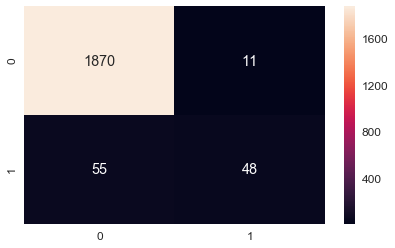

In [916]:
model.fit(X,Y)
#print pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:15]

y_pred = cross_val_predict(model,X,Y,cv=10)
from sklearn.metrics import roc_auc_score
print roc_auc_score(Y, y_pred)

# Classif report and conf mat
print sklearn.metrics.classification_report(Y, y_pred)
sns.heatmap(confusion_matrix(Y,y_pred),annot=True,fmt='2.0f')
plt.show()

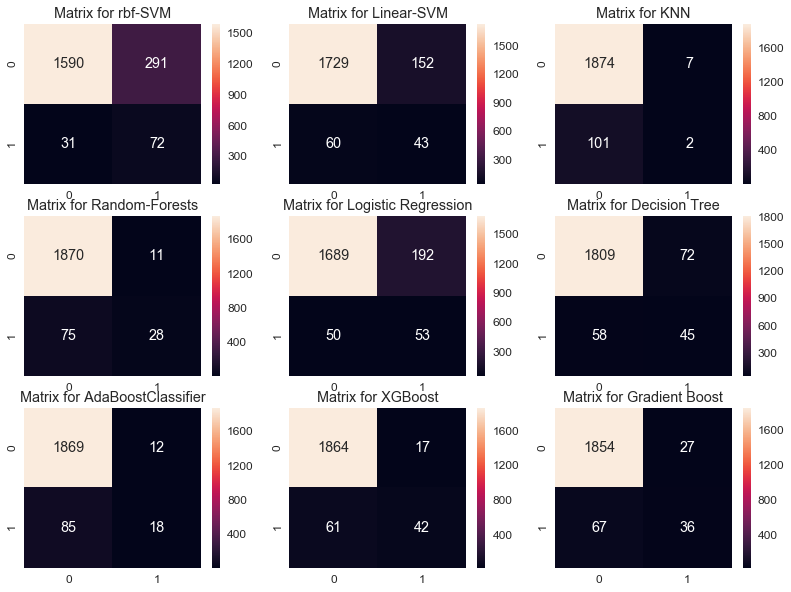

In [904]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf',class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')

y_pred = cross_val_predict(svm.SVC(kernel='linear',class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100,class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')

y_pred = cross_val_predict(LogisticRegression(class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')

y_pred = cross_val_predict(DecisionTreeClassifier(class_weight='balanced'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')

y_pred = cross_val_predict(AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for AdaBoostClassifier')

y_pred = cross_val_predict(xg.XGBClassifier(n_estimators=900,learning_rate=0.1),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,1],annot=True,fmt='2.0f')
ax[2,1].set_title('Matrix for XGBoost')

y_pred = cross_val_predict(GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,2],annot=True,fmt='2.0f')
ax[2,2].set_title('Matrix for Gradient Boost')



plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

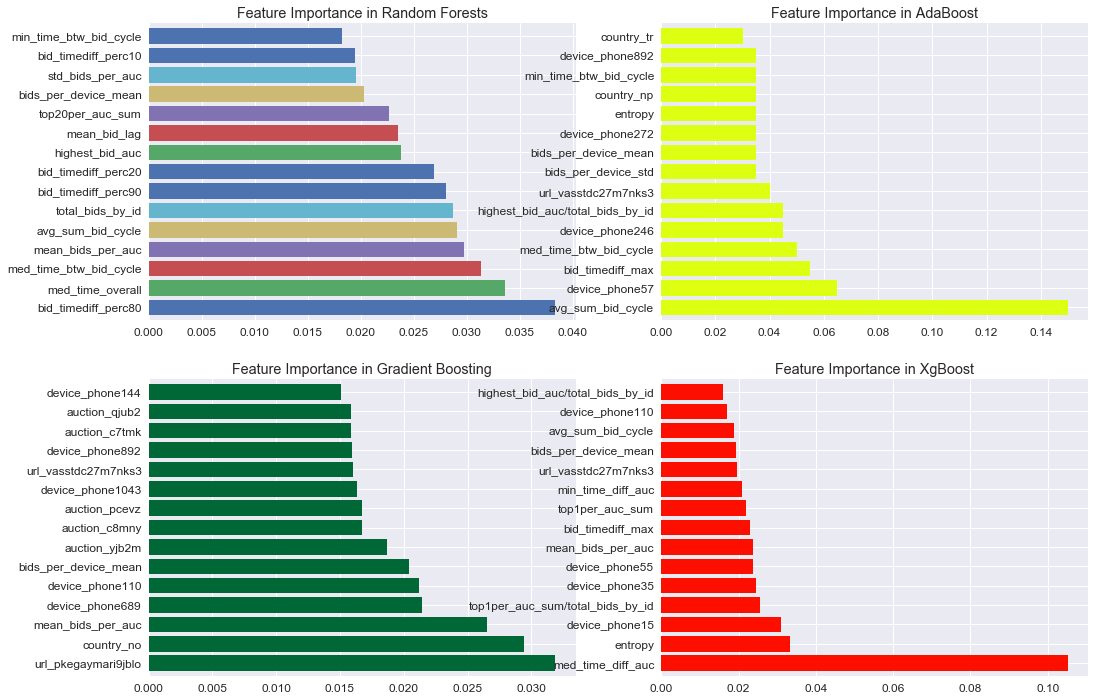

In [936]:
f,ax=plt.subplots(2,2,figsize=(15,12))
model=RandomForestClassifier(n_estimators=500,random_state=0,class_weight='balanced')
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=False)[:15].plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')

model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=False)[:15].plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')

model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=False)[:15].plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')

model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=False)[:15].plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')
plt.show()

The features generated from feature generation 2 have notably boosted the performance of some models. XGboost performs the best, so I will focus on tuning its hyperparameters in the next notebook.